# SOLAR POWER PREDICTION FROM WEATHER PARAMETERS
- This notebook contains the code implemented for this project.
- This is a capstone project for my introductory class of Data Analytics
- Forecasting solar energy is an important task to manage solar power systems, ensure power supply, and reduce operational risks. In this study, several machine learning models were compared in order to predict solar power from a power plant in Berkeley, California. The methodology in this study was applied using a distributed computing framework on Apache Spark. Data was collected from public databases and includes weather measurements recorded in 2008 and 2009. The results show that the random forest regression algorithm performed the best for predicting solar power, with an R-squared value of 89%. Finally, this model allowed for the identification of  which weather parameters are most important in predicting solar power.

In [0]:
# Libraries used in this project:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn modelling:
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Spark/ Spark ML Library:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
import mlflow.spark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler

# ML Flow:
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator





In [0]:
# SOLAR PLANT DATA SET
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/BigML_Dataset_5f50a4cc0d052e40e6000034.csv",
              'file:/tmp/BigML_Dataset_5f50a4cc0d052e40e6000034.csv')
solar_plant = pd.read_csv("file:/tmp/BigML_Dataset_5f50a4cc0d052e40e6000034.csv")

# SOLAR IRRADIANCE DATASET
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/2008.csv",'file:/tmp/2008.csv.csv')
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/2009.csv",'file:/tmp/2009.csv')
radiation_2008= pd.read_csv("file:/tmp/2008.csv.csv", header=2)
radiation_2009= pd.read_csv("file:/tmp/2009.csv",header=2)

dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/123795_37_89__122_30_2008.csv",
              'file:/tmp/123795_37_89__122_30_2008.csv')
temp = pd.read_csv('file:/tmp/123795_37_89__122_30_2008.csv')

/databricks/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
 interactivity=interactivity, compiler=compiler, result=result)

In [0]:
solar_plant.head()

Out[85]:

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


In [0]:
radiation_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 17 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Year 17520 non-null int64 
 1 Month 17520 non-null int64 
 2 Day 17520 non-null int64 
 3 Hour 17520 non-null int64 
 4 Minute 17520 non-null int64 
 5 DHI 17520 non-null int64 
 6 DNI 17520 non-null int64 
 7 GHI 17520 non-null int64 
 8 Cloud Type 17520 non-null int64 
 9 Dew Point 17520 non-null int64 
 10 Solar Zenith Angle 17520 non-null float64
 11 Surface Albedo 17520 non-null float64
 12 Wind Speed 17520 non-null float64
 13 Relative Humidity 17520 non-null float64
 14 Temperature 17520 non-null int64 
 15 Pressure 17520 non-null int64 
 16 Unnamed: 16 0 non-null float64
dtypes: float64(5), int64(12)
memory usage: 2.3 MB

# DATA CLEANING & PREPROCESSING
- This step consisted on formating time data, data types, merging datasets, and scaling features.

- Datetime configuration in the solar plant dataset:

In [0]:
# Replace discrete values to time format:
solar_plant['hour_time'] = solar_plant['First Hour of Period'].replace(
  [1,4,7,10,13,16,19,22],
  ['01:00', '04:00', '07:00','10:00', '13:00', '16:00','19:00','22:00'])

# Convert to datetime format:
solar_plant['DATE'] = solar_plant['Year'].map(str) + '-' + solar_plant['Month'].map(str) + '-' + solar_plant['Day'].map(str) + ' ' + solar_plant['hour_time'].map(str) 
solar_plant['DATE']= pd.to_datetime(solar_plant['DATE'])

Out[88]:

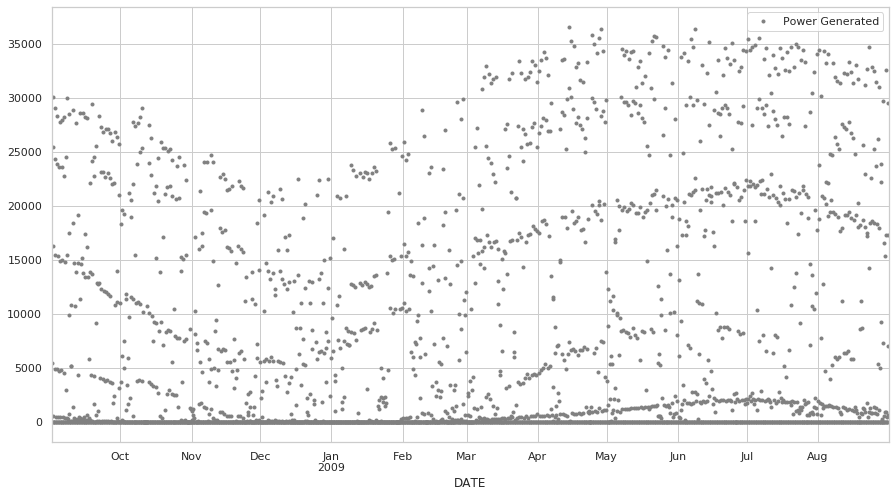

<matplotlib.axes._subplots.AxesSubplot at 0x7f0a18f58990>

In [0]:
solar_plant.plot(x= 'DATE', y='Power Generated', style='.', figsize = (15, 8), color='gray')
#solar_plant.groupby('DATE')['Power Generated'].agg('sum').plot(legend=True)

- Datetime and data type configuration in the solar irradiation datasets:

In [0]:
# Eliminate Unnamed:16 column
radiation_2008.drop('Unnamed: 16', axis=1,inplace=True)
radiation_2009.drop('Unnamed: 16', axis=1,inplace=True)

## CONFIGURATION OF DATE AND TIME, AND SAVING RESULTS AS DATAFRAME_CLEANED:
for df in [radiation_2008, radiation_2009]:
  df['DATE_TIME'] = df['Year'].map(str) + '-' + df['Month'].map(str) + '-' + df['Day'].map(str) + ' ' + df['Hour'].map(str)+ ':' + df['Minute'].map(str)
  df['DATE_TIME']= pd.to_datetime(df['DATE_TIME'])  

## CONFIGURATION OF VARIABLES TYPE:
for column in ['DHI','DNI','GHI','Solar Zenith Angle','Surface Albedo','Wind Speed', 'Relative Humidity', 'Temperature', 'Pressure']:
    radiation_2009[column]= radiation_2009[column].apply(lambda x: float(x))
    radiation_2008[column]= radiation_2008[column].apply(lambda x: float(x))

for column in ['Cloud Type','Dew Point']:
    radiation_2009[column]= radiation_2009[column].apply(lambda x: int(x))
    radiation_2008[column]= radiation_2008[column].apply(lambda x: int(x))



- Filter data recorded at night in the solar power plant
- Merge and re-arrange the three datasets into a new one called: weather_df

In [0]:
## ELiminate night recordings 
solar_plant= solar_plant[solar_plant['Is Daylight']== True]

## Eliminate zero recordings
solar_plant= solar_plant[solar_plant['Power Generated'] != 0]

## Set datetime as index to merge datasets by commong index
solar_plant.set_index('DATE', inplace= True)
radiation_2008.set_index('DATE_TIME', inplace=True)
radiation_2009.set_index('DATE_TIME', inplace=True)

# Merging process

## First concat radiation dataframes
radiation_df= pd.concat([radiation_2008, radiation_2009])

## Second merge with solar plant dataframe
weather_df=pd.merge(solar_plant,radiation_df, 
                how='inner', 
                left_index=True, 
                right_index=True
               )

## Re-arrange weather_df by eliminating similar columns
weather_df.drop([
  'Year_x', 'Month_x', 'Day_x','First Hour of Period',
  'Is Daylight','Year_y', 'Month_y', 'Day_y', 'Hour', 
  'Minute', 'Average Temperature (Day)', 
  'Average Wind Direction (Day)', 
  'Average Wind Speed (Day)', 'Relative Humidity_y', 
  'Pressure', 'hour_time', 'Day of Year', 
  'Average Wind Speed (Period)'], 
  axis=1, 
  inplace= True)

In [0]:
weather_df.columns

Out[57]: Index(['Distance to Solar Noon', 'Sky Cover', 'Visibility',
 'Relative Humidity_x', 'Average Barometric Pressure (Period)',
 'Power Generated', 'DHI', 'DNI', 'GHI', 'Cloud Type', 'Dew Point',
 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed', 'Temperature'],
 dtype='object')

Out[91]:

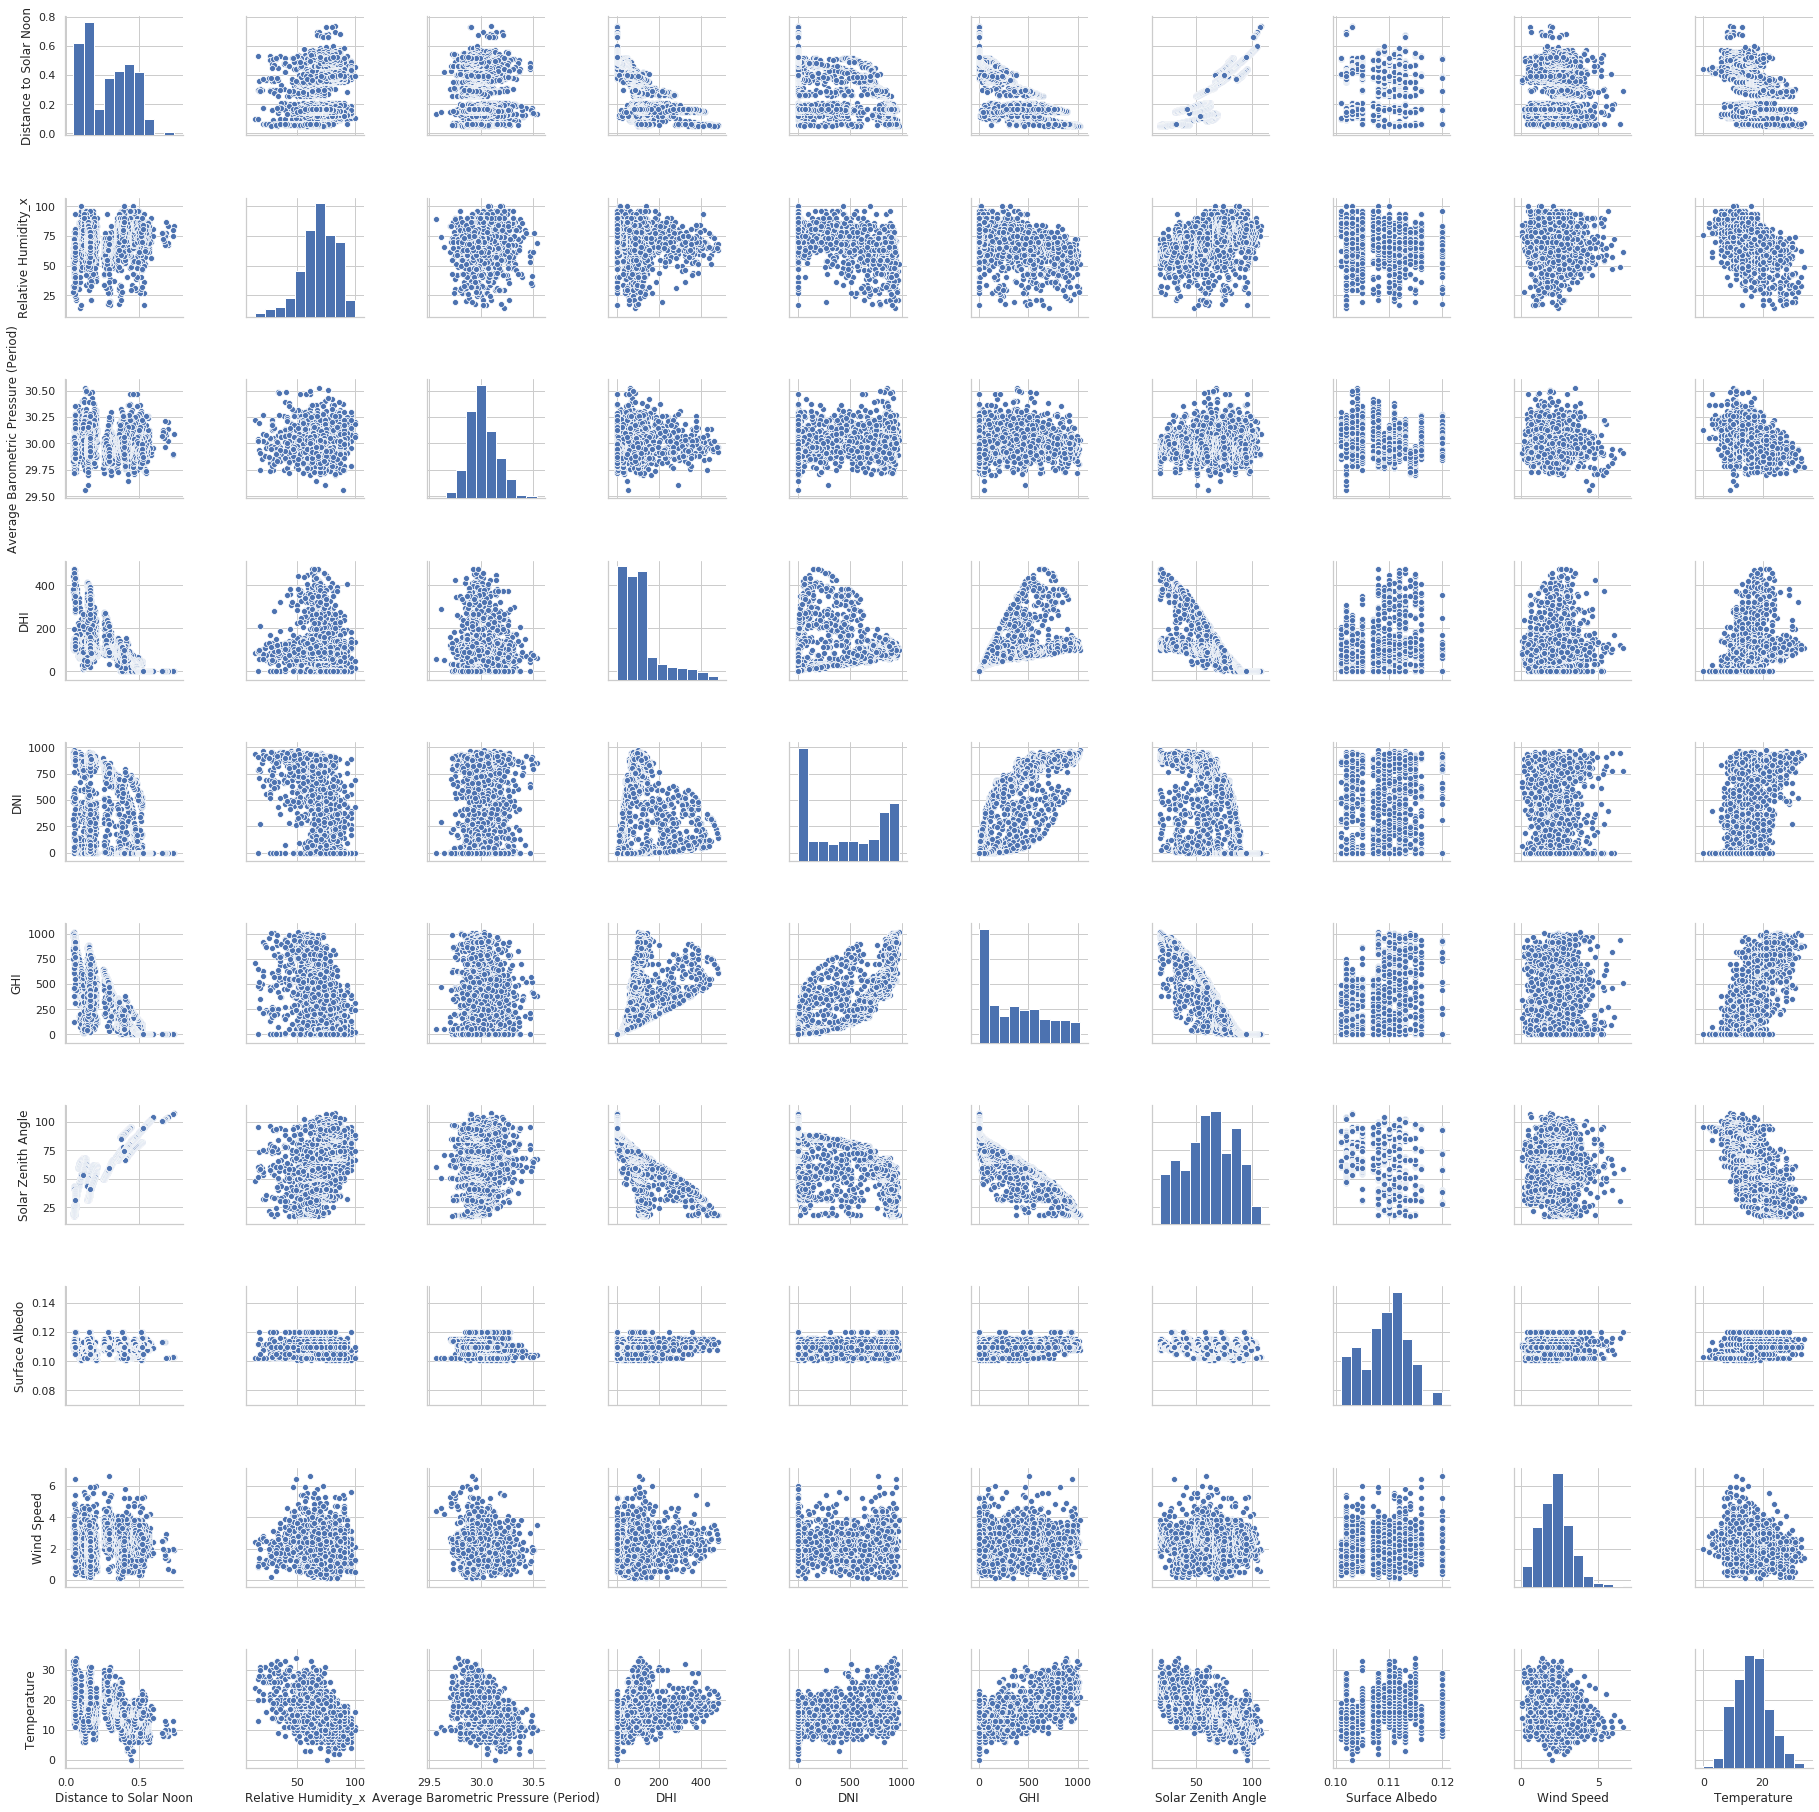

<seaborn.axisgrid.PairGrid at 0x7f0a19046450>

In [0]:
numeric_cols = ['Relative Humidity_x', 
        'Average Barometric Pressure (Period)',
        'Power Generated', 
        'DHI', 'DNI', 'GHI', 
        'Solar Zenith Angle', 
        'Wind Speed', 
        'Temperature']

sns.pairplot(data=weather_df[cols], 
             palette='rocket'
) 

Out[92]:

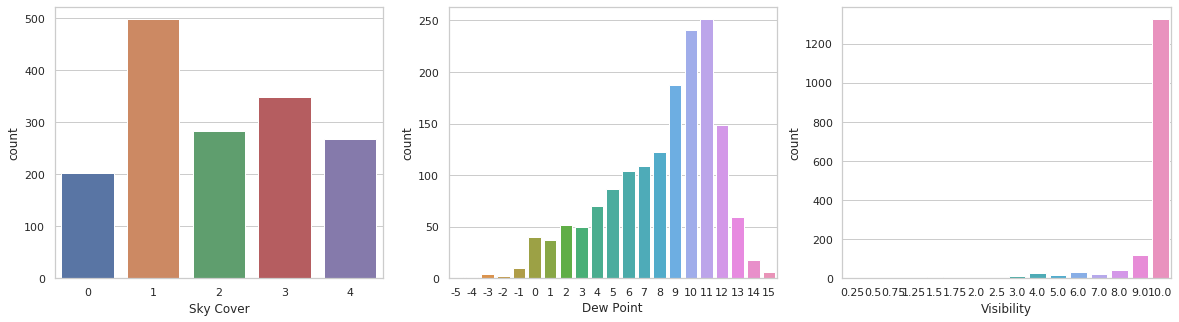

<matplotlib.axes._subplots.AxesSubplot at 0x7f0a0d266650>

In [0]:
# Plot of categorical variables
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.countplot(weather_df['Sky Cover'], ax=ax[0])
sns.countplot(weather_df['Dew Point'], ax=ax[1])
sns.countplot(weather_df['Visibility'], ax=ax[2])

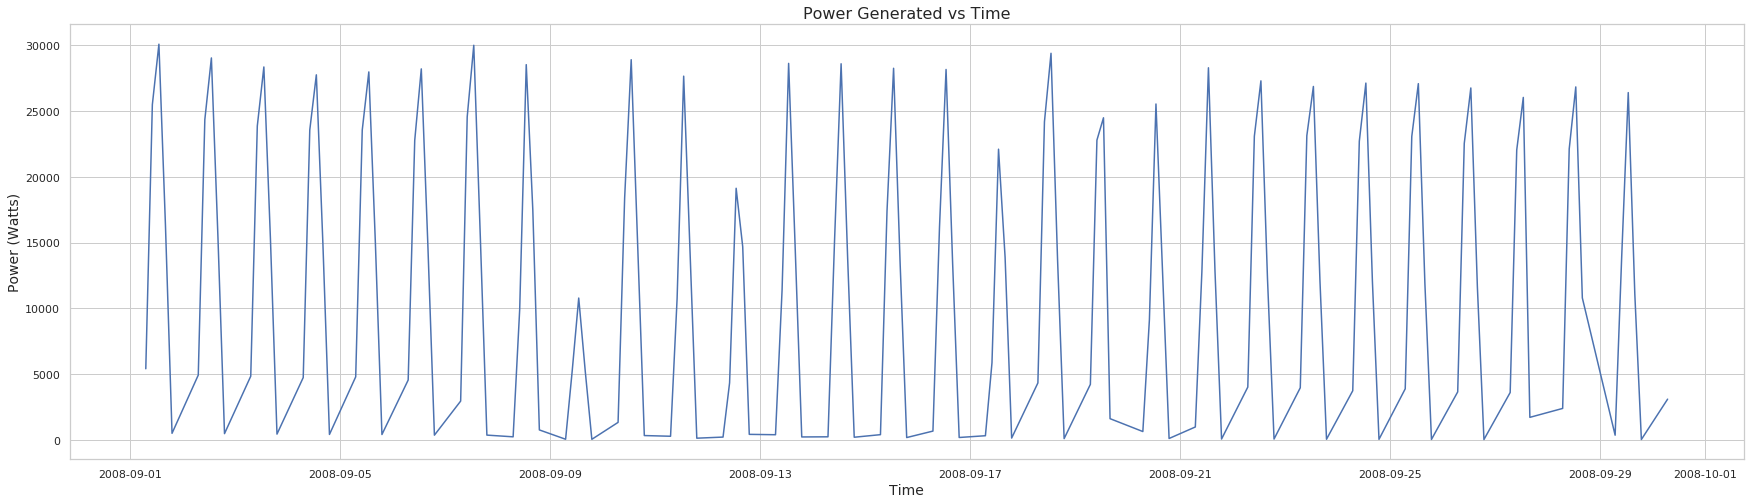

In [0]:
## TIME SERIES VISUALIZATIONS:
plt.figure(figsize=(30,8))
filter= solar_plant['2008-09-01 07:00:00': '2008-09-30 07:00:00']
sns.lineplot(x=filter.index, y=filter['Power Generated'], color='b')
plt.ylabel('Power (Watts)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Power Generated vs Time', fontsize=16)
plt.show()

/local_disk0/tmp/1614293845433-0/PythonShell.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
 # Databricks Python Shell
Out[94]:

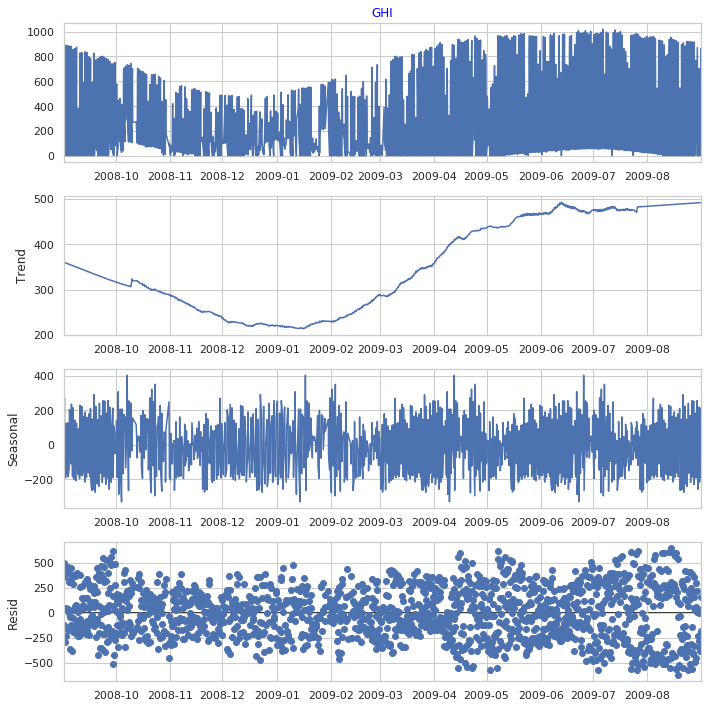

<Figure size 720x720 with 4 Axes>

In [0]:
# DECOMPOSITION
result_add= seasonal_decompose(weather_df['GHI'], model= 'additive', extrapolate_trend='freq', freq= 365)
plt.rcParams.update({'figure.figsize': (10,10), 'text.color':'blue'})
result_add.plot()


- Scaling Data

In [0]:
scaler = MinMaxScaler() 
weather_df_scaled = weather_df
cols= ['Distance to Solar Noon', 
       'Relative Humidity_x', 
       'Average Barometric Pressure (Period)', 
       'DHI', 'DNI', 'GHI','Solar Zenith Angle', 
       'Surface Albedo', 'Wind Speed', 'Temperature']
weather_df_scaled[cols] = scaler.fit_transform(weather_df_scaled[cols])

In [0]:
## transform result to data frame:
weather_df_scaled.head()

Out[96]:

,Distance to Solar Noon,Sky Cover,Visibility,Relative Humidity_x,Average Barometric Pressure (Period),Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Temperature
2008-09-01 07:00:00,0.504111,0,10.0,0.651163,0.340206,5418,0.123690,0.660825,0.219393,0,4,0.637497,0.526316,0.476923,0.500000
2008-09-01 10:00:00,0.167773,0,10.0,0.220930,0.360825,25477,0.201258,0.968041,0.780607,0,1,0.266756,0.526316,0.446154,0.705882
2008-09-01 13:00:00,0.022027,0,10.0,0.081395,0.340206,30069,0.213836,0.996907,0.903036,0,-1,0.159653,0.526316,0.369231,0.823529
2008-09-01 16:00:00,0.358365,0,10.0,0.069767,0.298969,16280,0.165618,0.873196,0.492654,0,-1,0.469272,0.526316,0.400000,0.823529
2008-09-01 19:00:00,0.694703,0,10.0,0.255814,0.278351,515,0.000000,0.000000,0.000000,0,3,0.861055,0.526316,0.323077,0.558824


In [0]:
weather_df_scaled.rename(columns={'Distance to Solar Noon':'Solar Noon',
                          'Relative Humidity_x': 'Humidity',
                          'Average Barometric Pressure (Period)': 'Pressure',
                          'Solar Zenith Angle': 'Zenith Angle',
                          'Surface Albedo': 'Albedo'
                         }, inplace=True)


In [0]:
weather_df_scaled.head()

Out[99]:

,Solar Noon,Sky Cover,Visibility,Humidity,Pressure,Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Zenith Angle,Albedo,Wind Speed,Temperature
2008-09-01 07:00:00,0.504111,0,10.0,0.651163,0.340206,5418,0.123690,0.660825,0.219393,0,4,0.637497,0.526316,0.476923,0.500000
2008-09-01 10:00:00,0.167773,0,10.0,0.220930,0.360825,25477,0.201258,0.968041,0.780607,0,1,0.266756,0.526316,0.446154,0.705882
2008-09-01 13:00:00,0.022027,0,10.0,0.081395,0.340206,30069,0.213836,0.996907,0.903036,0,-1,0.159653,0.526316,0.369231,0.823529
2008-09-01 16:00:00,0.358365,0,10.0,0.069767,0.298969,16280,0.165618,0.873196,0.492654,0,-1,0.469272,0.526316,0.400000,0.823529
2008-09-01 19:00:00,0.694703,0,10.0,0.255814,0.278351,515,0.000000,0.000000,0.000000,0,3,0.861055,0.526316,0.323077,0.558824


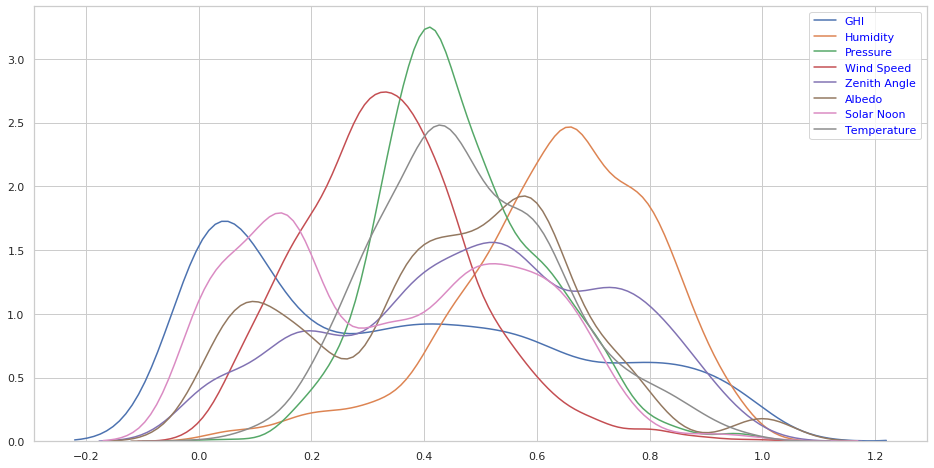

In [0]:
plt.figure(figsize= (16,8))
sns.kdeplot(weather_df_scaled['GHI'])
sns.kdeplot(weather_df_scaled['Humidity'])
sns.kdeplot(weather_df_scaled['Pressure'])
sns.kdeplot(weather_df_scaled['Wind Speed'])
sns.kdeplot(weather_df_scaled['Zenith Angle'])
sns.kdeplot(weather_df_scaled['Albedo'])
sns.kdeplot(weather_df_scaled['Solar Noon'])
sns.kdeplot(weather_df_scaled['Temperature'])
plt.show()

- Feature Selection
  - Based on this heatmap, power generated is correlated with all columns except Pressure, Dew Point, Wind Speed, Visibility
  - I will get rid of these variables and start building the model

Out[101]:

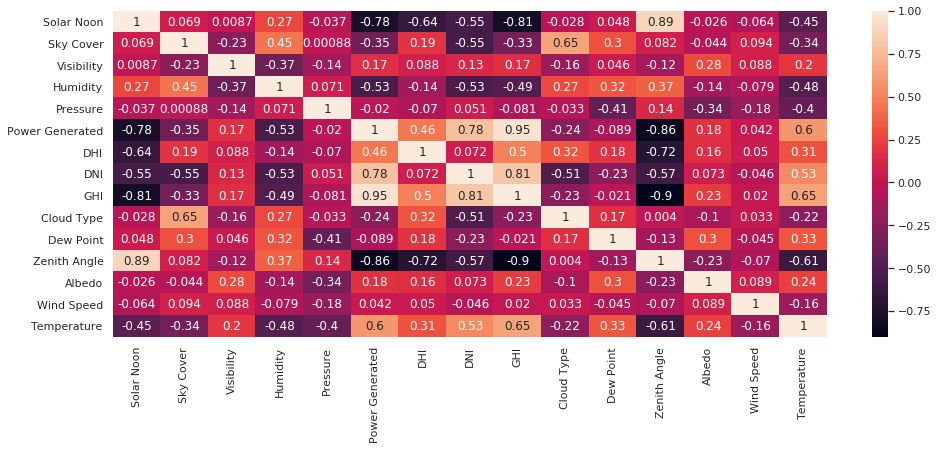

<matplotlib.axes._subplots.AxesSubplot at 0x7f0a0c184d50>

In [0]:
plt.figure(figsize=(16,6))
sns.heatmap(weather_df_scaled.corr(), annot= True)

# SPARK ML

- In this part of the notebook, I will move the dataset from pandas to spark dataframe.
- I will create a pipeline to build, evaluate and keep track of machine learning models.
- I will explore with random forests which are the variables that influence the most in solar energy production.

In [0]:
# So far, this is the dataset cleaned and arranged:
weather_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600 entries, 2008-09-01 07:00:00 to 2009-08-31 19:00:00
Data columns (total 15 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Solar Noon 1600 non-null float64
 1 Sky Cover 1600 non-null int64 
 2 Visibility 1600 non-null float64
 3 Humidity 1600 non-null float64
 4 Pressure 1600 non-null float64
 5 Power Generated 1600 non-null int64 
 6 DHI 1600 non-null float64
 7 DNI 1600 non-null float64
 8 GHI 1600 non-null float64
 9 Cloud Type 1600 non-null int64 
 10 Dew Point 1600 non-null int64 
 11 Zenith Angle 1600 non-null float64
 12 Albedo 1600 non-null float64
 13 Wind Speed 1600 non-null float64
 14 Temperature 1600 non-null float64
dtypes: float64(11), int64(4)
memory usage: 200.0 KB

In [0]:
## I will split data into training and test datasets.
weather_df_scaled.reset_index(inplace=True)
train_comp= weather_df_scaled.iloc[:len(weather_df_scaled)- 541] #541= 30% rows
test_comp= weather_df_scaled.iloc[len(weather_df_scaled)- 541:] 

## Then I will move both datasets to Spark dataframes:
train_spk_comp= spark.createDataFrame(train_comp)
test_spk_comp= spark.createDataFrame(test_comp)

train_spk_comp.cache().count()
test_spk_comp.cache().count()


Out[102]: 541

In [0]:
#TRANSFORM ALL INT AND LONG VARIABLE TYPS TO DOUBLE 
long_integer=['Day_Year', 'Year', 'Month', 'Day', 'Day_Avg_Temperature', 'Day_Avg_Wind_Direction', 'Sky Cover', 'Relative_Humidity', 'Cloud_Type', 'Dew Point']

long_double= ['Solar_Noon_Distance', 'Day_Avg_WSpeed', 'Visibility', 'Period_Avg_WSpeed', 'Period_Avg_Pressure', 'POWER', 'Diffuse_Horizontal_Irradiance','Direct_Normal_Irradiance ','Global_Horizontal_Irradiance', 'Zenith_Angle', 'Albedo']

for i in long_integer:
  train_spk_comp= train_spk_comp.withColumn(i,col(i).cast(IntegerType()))
for d in long_double:
  train_spk_comp= train_spk_comp.withColumn(d,col(d).cast(DoubleType()))

train_spk_comp= train_spk_comp.withColumn('Daylight', col('Daylight').cast(BooleanType()))


for i in long_integer:
  test_spk_comp= test_spk_comp.withColumn(i,col(i).cast(IntegerType()))
for d in long_double:
  test_spk_comp= test_spk_comp.withColumn(d,col(d).cast(DoubleType()))

test_spk_comp= test_spk_comp.withColumn('Daylight', col('Daylight').cast(BooleanType()))

- ML FLOW: Vector Assembler, Regression
  - Decision Tree
  - Random Forest
  - Linear Regression
  - Vector Assembler Regressor

# Decision Tree Regression

In [0]:
## DECISION TREE REGRESSOR ####
with mlflow.start_run(run_name='Decision-Tree-Regressor') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']
  
  #log parameters
  mlflow.log_param("label", "Decision-tree")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  dt = DecisionTreeRegressor(labelCol="Power Generated")
  pipeline_dt = Pipeline(stages=[vecAssembler, dt])
  pipelineModel_dt = pipeline_dt.fit(train_spk_comp)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_dt,'Decision_Tree_Pipeline')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_dt= pipelineModel_dt.transform(test_spk_comp)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_dt)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_dt)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_dt)
  
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid

# Random Forest Regression

In [0]:
## RANDOM FOREST REGRESSOR ####
with mlflow.start_run(run_name='Random-Forest-Regressor') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']
  
  #log parameters
  mlflow.log_param("label", "Random-Forest")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  rf = RandomForestRegressor(labelCol="Power Generated", featuresCol='features')
  pipeline_rf = Pipeline(stages=[vecAssembler, rf])
  pipelineModel_rf = pipeline_rf.fit(train_spk_comp)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_rf,'Random_Forest_Pipeline')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_rf= pipelineModel_rf.transform(test_spk_comp)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_rf)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_rf)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_dt)
  
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid
  

# Support Vector Machine

In [0]:
## UDF FUNCTION
with mlflow.start_run(run_name="Support Vector Machine") as run: 
  X = train_comp[['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']]
  y = train_comp["Power Generated"]

  svm = svm.SVR()
  svm.fit(X, y)
  
  mlflow.sklearn.log_model(svm, "support-vector-machine")
  mlflow.log_metric("rmse", mean_squared_error(test_comp['Power Generated'], svm.predict(test_comp[['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']])))
  mlflow.log_metric("mae", mean_absolute_error(test_comp['Power Generated'], svm.predict(test_comp[['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']])))
  mlflow.log_metric("r2", r2_score(test_comp['Power Generated'], svm.predict(test_comp[['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']])))
  
  runID = run.info.run_uuid
  experimentId = run.info.experiment_id
  URI = run.info.artifact_uri

In [0]:
## UDF CREATION


pyfunc_udf = mlflow.pyfunc.spark_udf(spark, URI + "/support-vector-machine")

In [0]:
## SVM ####
with mlflow.start_run(run_name='Support-Vector-Machine') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Albedo', 'Temperature', 'Cloud Type', 'Sky Cover','Visibility']
  
  #log parameters
  mlflow.log_param("label", "SVM")
  
  #Define pipeline
  #vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  #svm = RandomForestRegressor(labelCol="Power Generated", featuresCol='features')
  #pipeline_rf = Pipeline(stages=[vecAssembler, rf])
  #pipelineModel_rf = pipeline_rf.fit(train_spk_comp)
  
  #Log pipelineModel: model
  #mlflow.spark.log_model(svm,'support-vector-machine')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_svm= test_spk_comp.withColumn('prediction', pyfunc_udf(*test_spk_comp.columns))
  #pipelineModel_rf.transform(test_spk_comp)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  #rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_svm)
  #r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_svm)
  #mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_svm)
  
  #Log metrics
  #mlflow.log_metric('r2', r2)
  #mlflow.log_metric('rmse',rmse)
  #mlflow.log_metric('mae',mae)
  #runID= run.info.run_uuid

In [0]:
dtModel= pipelineModel_dt.stages[-1]
featuresDF = pd.DataFrame(list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)), columns=['feature', 'importance'])
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")
featuresDF['% importance']= featuresDF.importance.apply(lambda x: x*100)
featuresDF

RMSE is 3431.6026355681715
R2 is 0.9183139718301564
Out[108]:

,feature,importance,% importance
0,Solar Noon,0.005968,0.596843
1,Humidity,0.005958,0.595834
2,DHI,0.004136,0.413620
3,DNI,0.004484,0.448371
4,GHI,0.955411,95.541057
5,Zenith Angle,0.011942,1.194233
6,Albedo,0.001377,0.137696
7,Temperature,0.002288,0.228788
8,Cloud Type,0.000609,0.060892
9,Sky Cover,0.007827,0.782666


In [0]:
pandas_predDF_dt= predDF_dt.toPandas()
pandas_predDF_dt.head()

Out[83]:

,Solar Noon,Sky Cover,Visibility,Humidity,Pressure,Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Zenith Angle,Albedo,Wind Speed,Temperature,features,prediction
0,0.325994,2,10.0,0.627907,0.474227,19321,0.257862,0.735052,0.530852,0,13,0.403362,0.631579,0.584615,0.558824,"[0.3259940756663476, 0.627906976744186, 0.2578...",19412.924731
1,0.633120,4,6.0,0.883721,0.453608,1334,0.016771,0.010309,0.008815,0,12,0.789134,0.631579,0.400000,0.411765,"[0.6331196864564801, 0.8837209302325582, 0.016...",1137.750000
2,0.448232,3,10.0,0.837209,0.432990,5768,0.259958,0.387629,0.260529,3,11,0.558339,0.631579,0.215385,0.441176,"[0.4482322287271619, 0.8372093023255813, 0.259...",9524.839506
3,0.141467,1,10.0,0.651163,0.412371,29303,0.264151,0.886598,0.829579,0,12,0.171231,0.631579,0.246154,0.617647,"[0.14146667289928272, 0.6511627906976745, 0.26...",28849.833333
4,0.018760,2,10.0,0.593023,0.381443,33434,0.285115,0.911340,0.934378,1,11,0.049655,0.631579,0.276923,0.735294,"[0.01876044998663988, 0.5930232558139534, 0.28...",33755.038462


In [0]:
#DECISION TREES
pandas_predDF_dt= predDF_dt.toPandas()
pandas_predDF_dt['DATE_TIME']= pd.to_datetime(pandas_predDF_dt['index'])
pandas_predDF_dt.set_index('DATE_TIME', inplace=True)

#RANDOM FORESTS
pandas_predDF_rf= predDF_rf.toPandas()
pandas_predDF_rf['DATE_TIME']= pd.to_datetime(pandas_predDF_rf['index'])
pandas_predDF_rf.set_index('DATE_TIME', inplace=True)


In [0]:
pandas_predDF_dt.head()

Out[113]:

,index,Solar Noon,Sky Cover,Visibility,Humidity,Pressure,Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Zenith Angle,Albedo,Wind Speed,Temperature,features,prediction
DATE_TIME,,,,,,,,,,,,,,,,,,
2009-05-14 16:00:00,2009-05-14 16:00:00,0.325994,2,10.0,0.627907,0.474227,19321,0.257862,0.735052,0.530852,0,13,0.403362,0.631579,0.584615,0.558824,"[0.3259940756663476, 0.627906976744186, 0.2578...",19412.924731
2009-05-14 19:00:00,2009-05-14 19:00:00,0.633120,4,6.0,0.883721,0.453608,1334,0.016771,0.010309,0.008815,0,12,0.789134,0.631579,0.400000,0.411765,"[0.6331196864564801, 0.8837209302325582, 0.016...",1137.750000
2009-05-15 07:00:00,2009-05-15 07:00:00,0.448232,3,10.0,0.837209,0.432990,5768,0.259958,0.387629,0.260529,3,11,0.558339,0.631579,0.215385,0.441176,"[0.4482322287271619, 0.8372093023255813, 0.259...",9524.839506
2009-05-15 10:00:00,2009-05-15 10:00:00,0.141467,1,10.0,0.651163,0.412371,29303,0.264151,0.886598,0.829579,0,12,0.171231,0.631579,0.246154,0.617647,"[0.14146667289928272, 0.6511627906976745, 0.26...",28849.833333
2009-05-15 13:00:00,2009-05-15 13:00:00,0.018760,2,10.0,0.593023,0.381443,33434,0.285115,0.911340,0.934378,1,11,0.049655,0.631579,0.276923,0.735294,"[0.01876044998663988, 0.5930232558139534, 0.28...",33755.038462


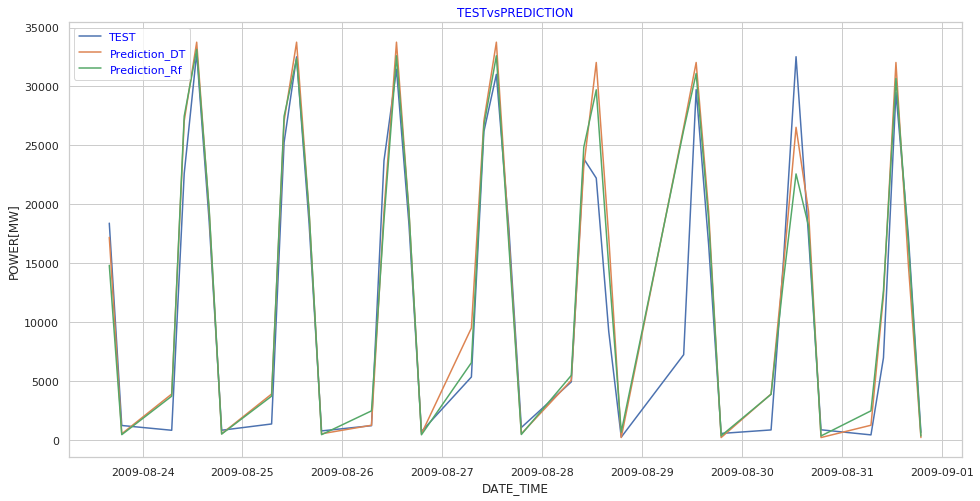

In [0]:
fig, ax= plt.subplots(figsize= (16,8))
sns.lineplot(x=pandas_predDF_dt.iloc[500:,:].index,y= pandas_predDF_dt.iloc[500:,6], ax=ax)
sns.lineplot(x=pandas_predDF_dt.iloc[500:,:].index,y= pandas_predDF_dt.iloc[500:,17], ax=ax, linestyle= ':' )
sns.lineplot(x=pandas_predDF_rf.iloc[500:,:].index,y= pandas_predDF_rf.iloc[500:,17], ax=ax, linestyle= ':' )
ax.legend(['TEST', 'Prediction_DT', 'Prediction_Rf'])
ax.set_title('TESTvsPREDICTION')
plt.ylabel('POWER[MW]')
plt.show()





In [0]:
experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae,metrics.rmse,metrics.r2,metrics.std_rmse,metrics.avg_rmse,metrics.r2_rf,metrics.rmse_rf,params.label,params.mlEstimatorUid,params.numTrees,params.maxDepth,params.mlModelClass,params.estimator,params.estimatorParamMapsLength,params.numFolds,params.evaluator,tags.mlflow.user,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.log-model.history,tags.fit_uuid,tags.mlflow.parentRunId,tags.mlflow.rootRunId,tags.runSource
e9da3f67ce2242f8b2a9e0a416a3be40,886128846365186,FINISHED,dbfs:/databricks/mlflow-tracking/886128846365186/e9da3f67ce2242f8b2a9e0a416a3be40/artifacts,2021-02-26T01:37:55.078+0000,2021-02-26T01:37:55.436+0000,null,null,null,null,null,null,null,SVM,null,null,null,null,null,null,null,null,jgarciag@gwmail.gwu.edu,1614303475546,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,Support-Vector-Machine,886128846365186,NOTEBOOK,"{""cluster_name"":""JGWU"",""spark_version"":""7.6.x-cpu-ml-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",0225-225129-plead510,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",null,null,null,null,null
2e5caaf201744c21b4195d7244f2ccfd,886128846365186,FINISHED,dbfs:/databricks/mlflow-tracking/886128846365186/2e5caaf201744c21b4195d7244f2ccfd/artifacts,2021-02-26T01:37:44.746+0000,2021-02-26T01:37:45.913+0000,11557.345934187853,1.8866387918159518E8,-0.3087073884521059,null,null,null,null,null,null,null,null,null,null,null,null,null,jgarciag@gwmail.gwu.edu,1614303466038,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,Support Vector Machine,886128846365186,NOTEBOOK,"{""cluster_name"":""JGWU"",""spark_version"":""7.6.x-cpu-ml-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",0225-225129-plead510,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}","[{""run_id"":""2e5caaf201744c21b4195d7244f2ccfd"",""artifact_path"":""support-vector-machine"",""utc_time_created"":""2021-02-26 01:37:45.008599"",""flavors"":{""python_function"":{""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""python_version"":""3.7.6"",""env"":""conda.yaml""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""0.22.1"",""serialization_format"":""cloudpickle""}}}]",null,null,null,null
856af3604e5546839f75f189a6bcfca9,886128846365186,FINISHED,dbfs:/databricks/mlflow-tracking/886128846365186/856af3604e5546839f75f189a6bcfca9/artifacts,2021-02-26T01:37:02.320+0000,2021-02-26T01:37:32.997+0000,2450.5834311126687,3431.6026355681715,0.9183139718301564,null,null,null,null,Random-Forest,null,null,null,null,null,null,null,null,jgarciag@gwmail.gwu.edu,1614303453135,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,/Users/jgarciag@gwmail.gwu.edu/SOLAR_FINAL,Random-Forest-Regressor,886128846365186,NOTEBOOK,"{""cluster_name"":""JGWU"",""spark_version"":""7.6.x-cpu-ml-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",0225-225129-plead510,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}","[{""run_id"":""856af3604e5546839f75f189a6bcfca9"",""artifact_path"":""Random_Forest_Pipeline"",""utc_time_created"":""2021-02-26 01:37:06.332539"",""flavors"":{""spark"":{""pyspark_version"":""3.0.0.dev0"",""model_data"":""sparkml""},""python_function"":{""loader_module"":""ml

# MODEL OPTIMIZATION 
Spark's ParamGridBuilder to find the optimal hyperparameters:
Let's define a grid of hyperparameters to test:
  - maxDepth: max depth of the decision tree (Use the values `2, 5, 10`)
  - numTrees: number of decision trees (Use the values `10, 20, 100`)

CROSS VALIDATION
  - We are going to do 3-Fold cross-validation, with `parallelism`=4, and set the `seed`=42 on the cross-validator for reproducibility.

In [0]:
## optimization with grid search

paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [2, 5, 10])
            .addGrid(rf.numTrees,[10,20,100])
            .build())

In [0]:
evaluator = RegressionEvaluator(labelCol="Power Generated", predictionCol="prediction")

cv = CrossValidator(estimator=rf, evaluator= evaluator, estimatorParamMaps=paramGrid, numFolds=3, parallelism=4, seed=42 )

In [0]:
stages = [vecAssembler, cv]

pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(train_spk_comp)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
predDF_cv_dt = pipelineModel.transform(test_spk_comp)

rmse = evaluator.evaluate(predDF_cv_dt)
r2 = evaluator.setMetricName("r2").evaluate(predDF_cv_dt)
mae = evaluator.setMetricName("mae").evaluate(predDF_cv_dt)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")
print(f"MAE is {mae}")

RMSE is 3412.9414135883862
R2 is 0.9191999813661482
MAE is 1980.7613108891042

In [0]:
cvModel = pipelineModel.stages[-1]
rfModel = cvModel.bestModel

list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

print(rfModel.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: auto)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: Power Generated)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
minWeightFractionPerNode: Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5). (default: 0.0)
numTrees: Number of trees to train (>= 1). (default: 20, current: 100)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 2502083311556356884)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

Out[121]:

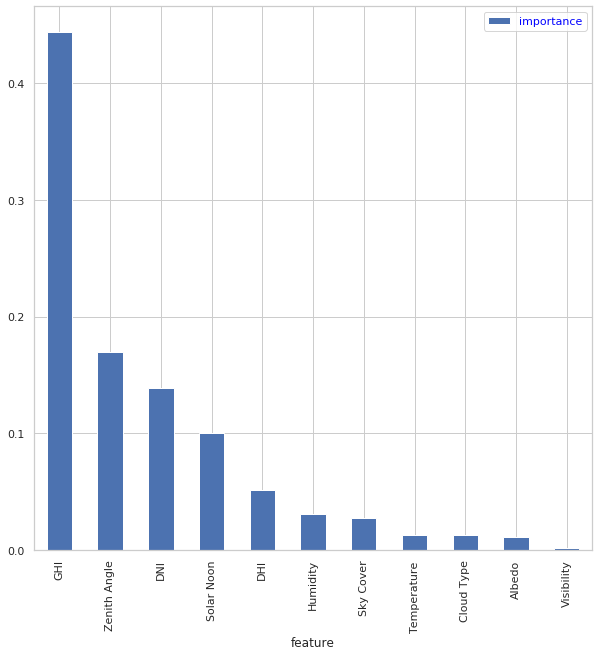

<matplotlib.axes._subplots.AxesSubplot at 0x7f0a0bccd4d0>

In [0]:
pandasDF = pd.DataFrame(list(zip(vecAssembler.getInputCols(), rfModel.featureImportances)), columns=["feature", "importance"])
topFeatures = pandasDF.sort_values(["importance"], ascending=False)
topFeatures.plot.bar(x='feature', y='importance')

In [0]:
predDF_cv_dt

Out[123]: DataFrame[index: timestamp, Solar Noon: double, Sky Cover: bigint, Visibility: double, Humidity: double, Pressure: double, Power Generated: bigint, DHI: double, DNI: double, GHI: double, Cloud Type: bigint, Dew Point: bigint, Zenith Angle: double, Albedo: double, Wind Speed: double, Temperature: double, features: vector, prediction: double]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

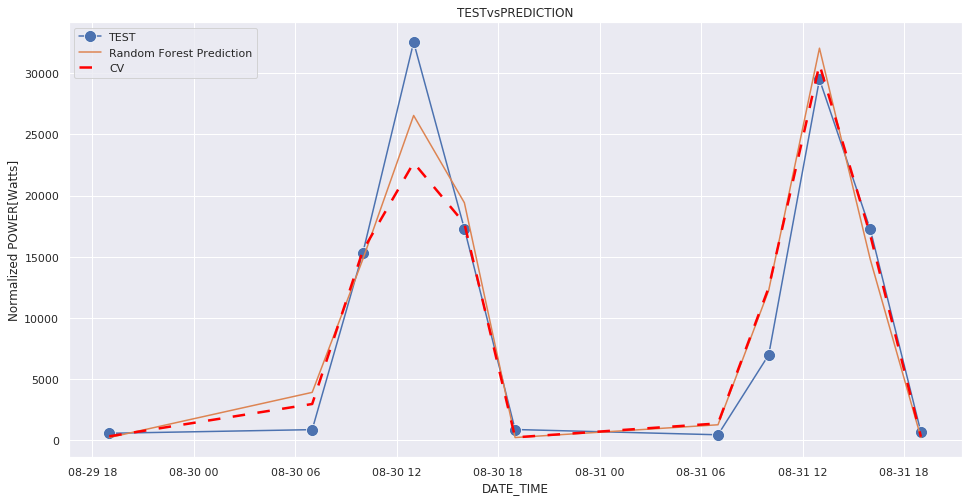

In [0]:


#DECISION TREES
#pandas_predDF_dt= predDF_dt.toPandas()
#pandas_predDF_dt['DATE_TIME']= pd.to_datetime(pandas_predDF_dt['DATE'])
#pandas_predDF_dt.set_index('DATE', inplace=True)

#RANDOM FORESTS
#pandas_predDF_rf= predDF_rf.toPandas()
#pandas_predDF_rf['DATE_TIME']= pd.to_datetime(pandas_predDF_rf['DATE'])
#pandas_predDF_rf.set_index('DATE', inplace=True)

#CROSS VALIDATION
pandas_predDF_cv= predDF_cv_dt.toPandas()
pandas_predDF_cv['DATE_TIME']= pd.to_datetime(pandas_predDF_cv['index'])
pandas_predDF_cv.set_index('DATE_TIME', inplace=True)


fig, ax= plt.subplots(figsize= (16,8))
#DECISION TREES
sns.lineplot(x=pandas_predDF_dt.iloc[530:,:].index,y= pandas_predDF_dt.iloc[530:,6], ax=ax, marker='o', markersize=12)
sns.lineplot(x=pandas_predDF_dt.iloc[530:,:].index,y= pandas_predDF_dt.iloc[530:,17], ax=ax, linestyle= ':', markers=True )
#sns.lineplot(x=pandas_predDF_rf.iloc[530:,:].index,y= pandas_predDF_rf.iloc[530:,16], ax=ax, linestyle= ':', markers=True )
sns.lineplot(x=pandas_predDF_cv.iloc[530:,:].index,y= pandas_predDF_cv.iloc[530:,17], ax=ax, style=True, dashes=[(5,5)], linewidth=2.5, color='red' )
ax.legend(['TEST', 'Random Forest Prediction', 'CV'])
ax.set_title('TESTvsPREDICTION')
plt.ylabel('Normalized POWER[Watts]')
plt.show()

In [0]:
pandas_predDF_cv

Out[125]:

,index,Solar Noon,Sky Cover,Visibility,Humidity,Pressure,Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Zenith Angle,Albedo,Wind Speed,Temperature,features,prediction
DATE_TIME,,,,,,,,,,,,,,,,,,
2009-05-14 16:00:00,2009-05-14 16:00:00,0.325994,2,10.0,0.627907,0.474227,19321,0.257862,0.735052,0.530852,0,13,0.403362,0.631579,0.584615,0.558824,"[0.3259940756663476, 0.627906976744186, 0.2578...",19683.655373
2009-05-14 19:00:00,2009-05-14 19:00:00,0.633120,4,6.0,0.883721,0.453608,1334,0.016771,0.010309,0.008815,0,12,0.789134,0.631579,0.400000,0.411765,"[0.6331196864564801, 0.8837209302325582, 0.016...",911.494086
2009-05-15 07:00:00,2009-05-15 07:00:00,0.448232,3,10.0,0.837209,0.432990,5768,0.259958,0.387629,0.260529,3,11,0.558339,0.631579,0.215385,0.441176,"[0.4482322287271619, 0.8372093023255813, 0.259...",7902.673031
2009-05-15 10:00:00,2009-05-15 10:00:00,0.141467,1,10.0,0.651163,0.412371,29303,0.264151,0.886598,0.829579,0,12,0.171231,0.631579,0.246154,0.617647,"[0.14146667289928272, 0.6511627906976745, 0.26...",28420.539760
2009-05-15 13:00:00,2009-05-15 13:00:00,0.018760,2,10.0,0.593023,0.381443,33434,0.285115,0.911340,0.934378,1,11,0.049655,0.631579,0.276923,0.735294,"[0.01876044998663988, 0.5930232558139534, 0.28...",32110.337379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-31 07:00:00,2009-08-31 07:00:00,0.503755,4,10.0,0.848837,0.350515,464,0.098532,0.000000,0.046033,3,12,0.635271,0.210526,0.369231,0.441176,"[0.5037546571354063, 0.8488372093023255, 0.098...",1391.462437
2009-08-31 10:00:00,2009-08-31 10:00:00,0.168709,4,10.0,0.709302,0.381443,6995,0.704403,0.071134,0.380020,3,12,0.263527,0.210526,0.369231,0.558824,"[0.1687085362734437, 0.7093023255813953, 0.704...",12489.139569
2009-08-31 13:00:00,2009-08-31 13:00:00,0.019799,1,10.0,0.604651,0.360825,29490,0.243187,0.906186,0.846229,0,12,0.154531,0.210526,0.400000,0.617647,"[0.019799150192834458, 0.6046511627906976, 0.2...",30706.000573


Out[136]:

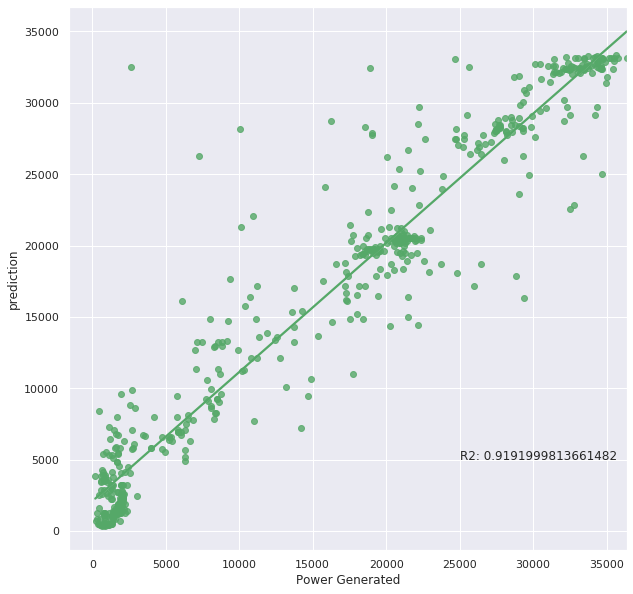

Text(25000, 5000, 'R2: 0.9191999813661482')

In [0]:
sns.regplot(x='Power Generated',y='prediction',data= pandas_predDF_rf, color='g', ci=True)
plt.annotate('R2: {}'.format(r2),(25000, 5000))

In [0]:
experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.std_rmse,metrics.avg_rmse,metrics.mae,metrics.rmse,metrics.r2,metrics.r2_rf,metrics.rmse_rf,params.mlEstimatorUid,params.numTrees,params.maxDepth,params.mlModelClass,params.estimator,params.estimatorParamMapsLength,params.numFolds,params.evaluator,params.label,tags.fit_uuid,tags.mlflow.parentRunId,tags.mlflow.user,tags.mlflow.rootRunId,tags.runSource,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.cluster.libraries,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.runName,tags.mlflow.log-model.history
08748e942f19488ab0b70ef5500c809f,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/08748e942f19488ab0b70ef5500c809f/artifacts,2021-02-26T01:50:50.189+0000,null,107.1773835259136,2698.797692645779,null,null,null,null,null,RandomForestRegressor_747d6730873a,100,10,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
e4e08b0d9a6e4a46a736d65a93aaea28,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/e4e08b0d9a6e4a46a736d65a93aaea28/artifacts,2021-02-26T01:50:48.937+0000,null,134.88769744126694,2770.104574751782,null,null,null,null,null,RandomForestRegressor_747d6730873a,20,10,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
85c15171c8e640cabf848cf6ffbb7b7e,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/85c15171c8e640cabf848cf6ffbb7b7e/artifacts,2021-02-26T01:50:47.645+0000,null,65.94453272401341,2808.5494102688394,null,null,null,null,null,RandomForestRegressor_747d6730873a,10,10,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
9d8b2f93ddd4402a96f8724a24865ab8,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/9d8b2f93ddd4402a96f8724a24865ab8/artifacts,2021-02-26T01:50:46.352+0000,null,71.18991715932941,2832.2530920696786,null,null,null,null,null,RandomForestRegressor_747d6730873a,100,5,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
e782c9c8ea744da485cf73376ca9b38b,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/e782c9c8ea744da485cf73376ca9b38b/artifacts,2021-02-26T01:50:44.911+0000,null,71.38829948742051,2864.4270140420135,null,null,null,null,null,RandomForestRegressor_747d6730873a,20,5,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
972388d9e794421ea59b34771979717c,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/972388d9e794421ea59b34771979717c/artifacts,2021-02-26T01:50:43.606+0000,null,21.119394014813768,2878.218552267173,null,null,null,null,null,RandomForestRegressor_747d6730873a,10,5,RandomForestRegressor,null,null,null,null,null,03e92c,769c75d40f8c42ac8d42e55912e6f469,jgarciag@gwmail.gwu.edu,769c75d40f8c42ac8d42e55912e6f469,mllibAutoTracking,null,null,null,null,null,null,null,null,null,null,null
608c5d17343c438faa2c7c9a9afbdb4e,886128846365186,RUNNING,dbfs:/databricks/mlflow-tracking/886128846365186/608c5d17343c438faa2c7c9a9afbdb4e/artifacts,2021-02-26T01:50:42.242+0000,null,117.06672137242273,3752.0